# Cartpole game using Policy Gradient

In [7]:
%matplotlib inline

import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt

import gym

In [2]:
class Agent(object):
    
    def __init__(self,state_size, action_size):
        
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99        #discount rate
        self.states = []
        self.rewards = []
        self.actions = []
        self.model = self._build_model()
        self._build_train()    
    
    def _build_model(self):
        # creates the base model
        
        self.X = Input(shape=(self.state_size,))
        net = self.X
        
        net = Dense(64, activation='relu')(net)
        net = Dense(32, activation='relu')(net)
        
        net = Dense(self.action_size, activation='softmax')(net)
        
        return Model(inputs = self.X , outputs = net )
            
    
       

    def _build_train(self):
        """
        modified train function
        calculates the loss and updates the weight
        loss is the mean log value
        """
        
        
        action_prob = self.model.output                  #probabilites of actions at given state
        action_taken = K.placeholder(shape = (None,self.action_size), name= 'action_taken') # one-hot-encode form of action
        rewards = K.placeholder(shape = (None,), name = 'rewards') #discounted rewards
        
        action_taken_prob = K.sum(action_prob*action_taken, axis=1)  # probability of action taken
        log_action_prob = K.log(action_taken_prob) 
        l = - log_action_prob * rewards  # scale the value according to rewards. most recent actions get the negative rewards
        loss = K.mean(l)         #computes the loss
        
        adam = Adam()            #optimizer
        updates = adam.get_updates(params=self.model.weights,
                                   loss=loss)
        
        self.fit  = K.function(inputs= [self.model.input, action_taken, rewards], 
                              outputs = [l], 
                              updates = updates)    
     
    
    def remember(self, state, action, reward):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)
    
    def act(self,state):
        action_prob = np.squeeze(self.model.predict(state))
        return np.random.choice(np.arange(self.action_size), p=action_prob)   #It is like tossing a biased coin

    
    def discount_rewards(self, R):
        
        """
        The end of the game is mainly due to the recent actions
        Hence the recent reward values are penalized
        this method converts reward keeping in mind the above points
        rewards decreases with time exponentially
        """
        
        
        discounted_r = np.zeros_like(R, dtype=np.float32)
        running_add = 0
        for t in reversed(range(len(R))):

            running_add = running_add * self.gamma + R[t]
            discounted_r[t] = running_add

        discounted_r -= discounted_r.mean() / discounted_r.std()
        return discounted_r
    
    
    def train(self):
        rewards = np.array(self.rewards)
        rewards = self.discount_rewards(rewards)
        action = to_categorical(self.actions,num_classes = self.action_size) #converts to one-hot-encoding
        states = np.vstack(self.states)
        self.fit([ states, action, rewards])   #custom training function
        self.states,self.actions, self.rewards = [],[],[]
        
    def load(self,f):
        self.model.load_weights(f)
    
    def save(self,f):
        self.model.save_weights(f)
        
    def play(self):
        done = False
        env = gym.make('CartPole-v0')
        state = env.reset()
        score = 0
        while not done:
#             env.render()
            state = np.reshape(state, [1,self.state_size])
            action = self.act(state)
            newState, reward, done, _ = env.step(action)
            score += reward
            state = newState
        env.close()
        return score

In [4]:
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(state_size, action_size)
# agent.load('policy_gradient.h5')
episode = 0
score = 0
maxEpisode = 1000

state = env.reset()

while episode < maxEpisode:
#     env.render()
    
    state = np.reshape(state, [1,state_size])
    action = agent.act(state)
    newState, reward, done, _ = env.step(action)
    score += reward
    
    agent.remember(state = state, action = action, reward = reward)
    state = newState
    
    if done:
        
        episode += 1
        agent.train()
        if episode %100 == 0:
            print ('episode - {} score - {}').format(episode, score)
        score = 0
        state = env.reset()
        
        if episode > 1 and episode %1000 == 0:
            agent.save('cartPole.h5')
            
env.close()

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


In [5]:
score = []
for i in range(100):
    score.append(agent.play())

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box

In [6]:
print "average score for 100 consecutive trial is {}".format(np.mean(np.array(score)) )

average score for 100 consecutive trial is 195.67


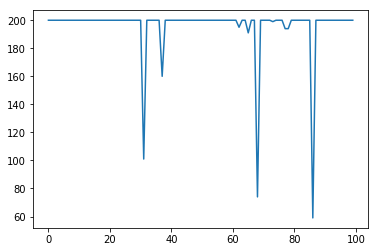

In [12]:
plt.plot(score)